In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, LabelBinarizer
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,learning_curve
from sklearn.feature_selection import SelectKBest, f_regression, chi2 , f_classif, VarianceThreshold

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score

from sklearn import set_config

In [3]:
# Fonction de suivit des colonnes en sortie et Transformer de cette fonction

def debug_columns(X):
    print('Output Column:')
    print(X.columns)
    return X

#Transformer de cette fonction
debug_transformer = FunctionTransformer(debug_columns)

Importation des données

In [4]:
data_train = pd.read_csv("segmentation_client_Train.csv")
data_test = pd.read_csv("segmentation_client_Test.csv")

In [5]:
df = data_train.drop(labels=["Segmentation", "ID"], axis=1)

In [6]:
df.shape

(8068, 9)

Analyse des valeurs manquantes 

<Axes: >

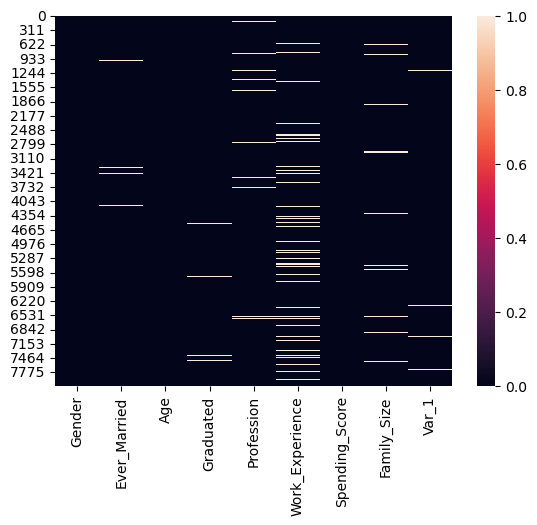

In [7]:
sns.heatmap(df.isna())

In [8]:
df = df.drop(labels="Work_Experience", axis=1)

In [9]:
df.dropna(axis=0,inplace=True)

In [10]:
df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Spending_Score,Family_Size,Var_1
0,Male,No,22,No,Healthcare,Low,4.0,Cat_4
1,Female,Yes,38,Yes,Engineer,Average,3.0,Cat_4
2,Female,Yes,67,Yes,Engineer,Low,1.0,Cat_6
3,Male,Yes,67,Yes,Lawyer,High,2.0,Cat_6
4,Female,Yes,40,Yes,Entertainment,High,6.0,Cat_6


#### Analyse Statistiques Univariée 

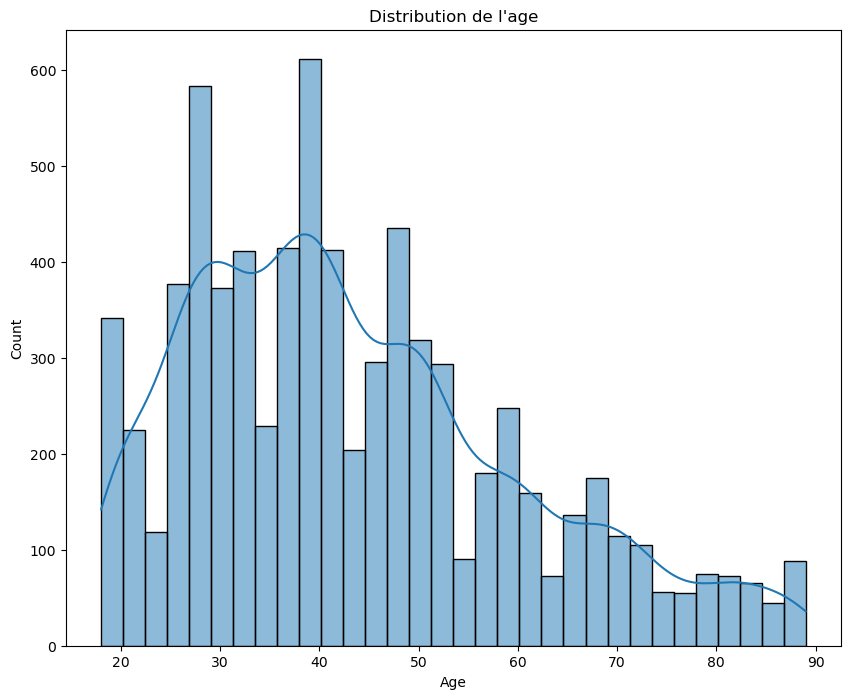

In [11]:
plt.figure(figsize=(10,8))
sns.histplot(data=df, x="Age", kde=True)
plt.xlabel("Age")
plt.title("Distribution de l'age")
plt.show()

Graphique des variables categorielles 

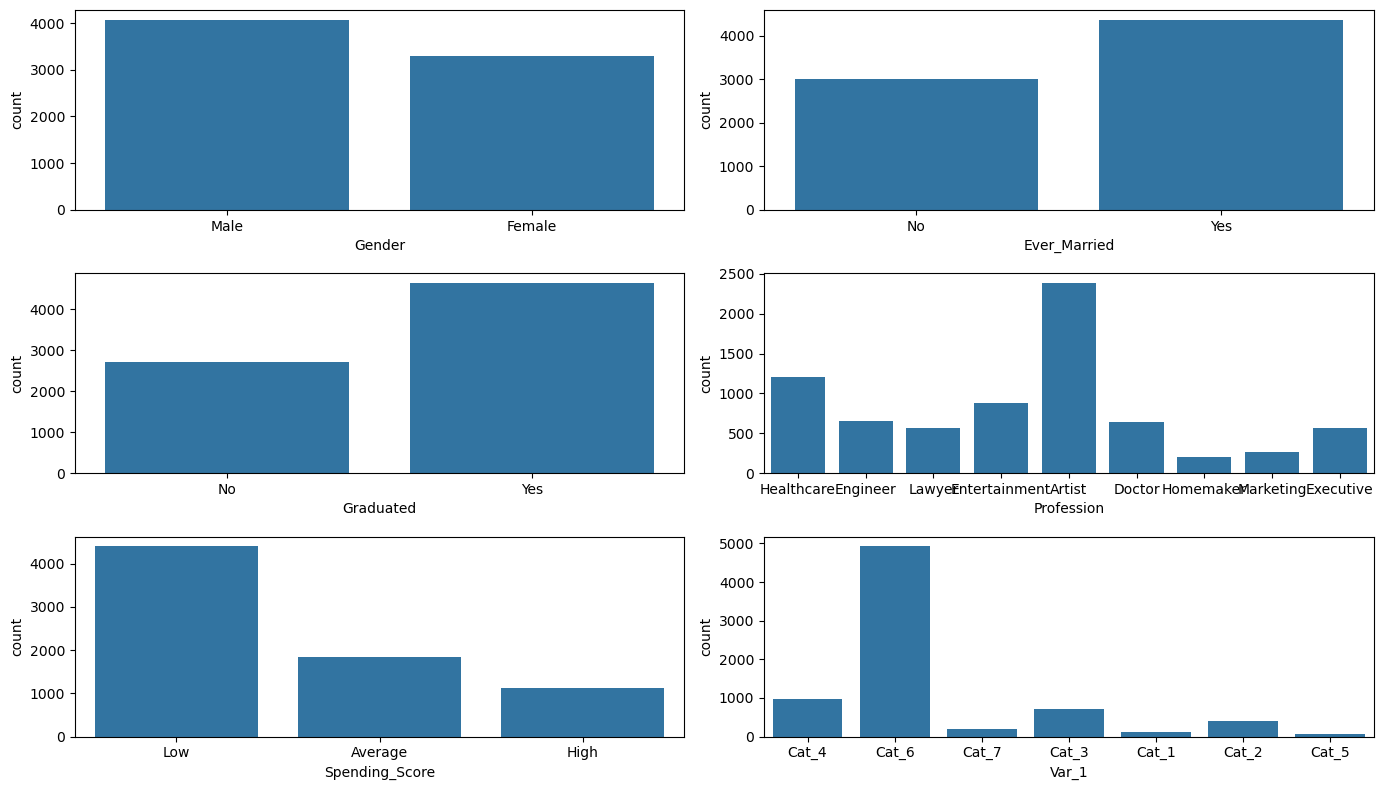

In [12]:
var_col = [col for col in df.select_dtypes("object")]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14,8))
axes = axes.flatten()

for ax, col in zip(axes,var_col):

    sns.countplot(data=df, x=col, ax=ax)
plt.tight_layout()
plt.show()

Preprocessing 

In [13]:
set_config(transform_output='pandas')

In [14]:
col_cat = ["Gender", "Var_1", "Profession", "Graduated", "Ever_Married"]
col_ord = ["Spending_Score"]
spen_scor = ["Low","Average", "High"]

In [15]:
Colums_transform = ColumnTransformer(
    transformers=[
                  ("col_cat", OneHotEncoder(sparse_output=False, drop='first'), col_cat),
                  ("col_ordin",OrdinalEncoder(categories=[spen_scor]),col_ord),             
],
remainder="passthrough",
verbose_feature_names_out=False
)
preprocessor = make_pipeline(Colums_transform, StandardScaler())

In [16]:
X = preprocessor.fit_transform(df)

In [17]:
X.shape

(7376, 20)

Correlation des variabels 

<Axes: >

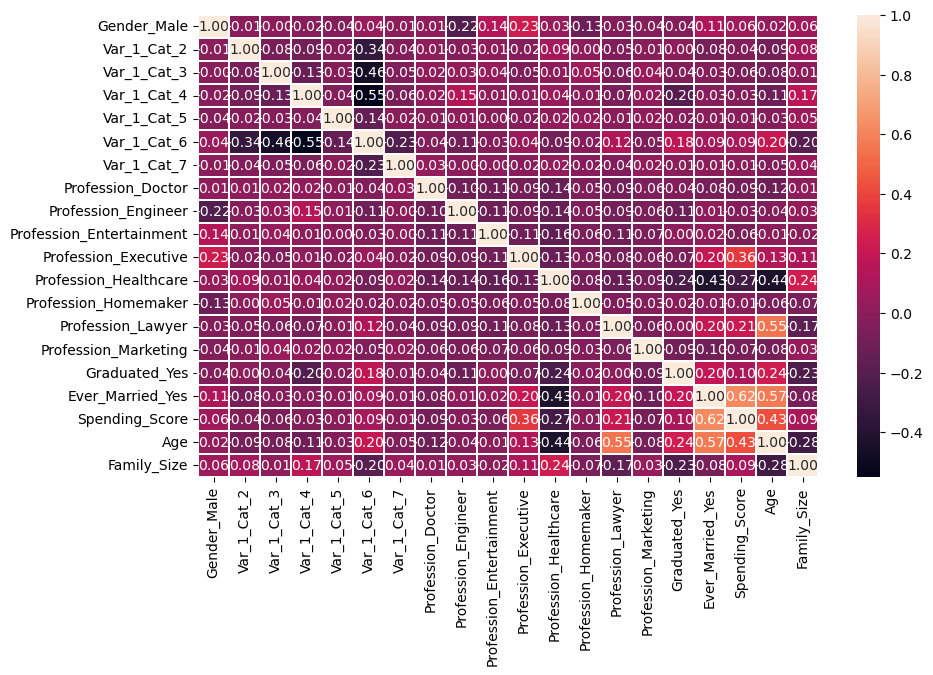

In [18]:
corr = X.corr(method="pearson")
plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True,fmt=".2f", linewidth=.2)

PCA

In [19]:
n_components = 7
pca = PCA(n_components=n_components)
pca.fit(X)

PCA(n_components=7)

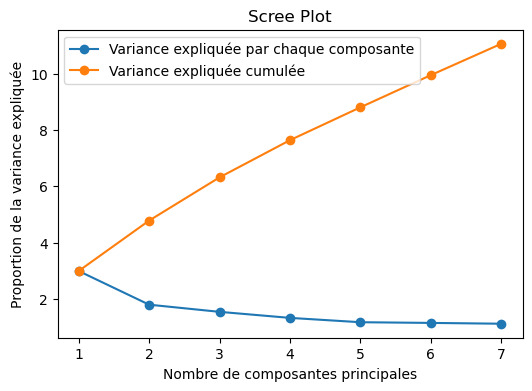

In [20]:
# Calculer la variance expliquée cumulée
explained_variance = pca.explained_variance_

cumulative_explained_variance = np.cumsum(explained_variance)

# Créer un scree plot avec la variance expliquée cumulée
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'o-', label='Variance expliquée par chaque composante')
plt.plot(range(1, len(explained_variance) + 1), cumulative_explained_variance, 'o-', label='Variance expliquée cumulée')
plt.title('Scree Plot')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Proportion de la variance expliquée')
plt.legend()
plt.show()

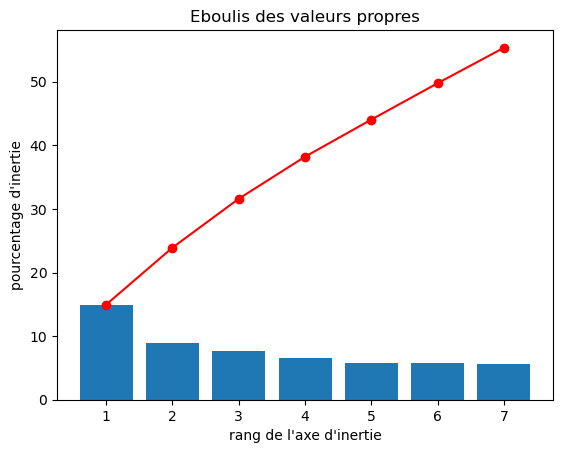

In [21]:
scree = (pca.explained_variance_ratio_*100).round(2)
x_list = range(1, n_components+1)

scree_cum = scree.cumsum().round(2)

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum, c="red", marker="o")
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

Application de la methode Kmeans 

In [22]:
X_proj = pca.transform(X)
X_df = pd.DataFrame(X_proj, columns=[f'F{i+1}' for i in range(n_components)])

In [23]:

# Une liste vide pour enregistrer les inerties :  
intertia_list = [ ]

silhouette = []
# Notre liste de nombres de clusters : 
k_list = range(2, 15)

# Pour chaque nombre de clusters : 
for k in k_list : 
    
    # On instancie un k-means pour k clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    # On entraine
    kmeans.fit(X)
    
    # On enregistre l'inertie obtenue : 
    intertia_list.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X, kmeans.labels_))

##### Affichage de la courbe d'inertie

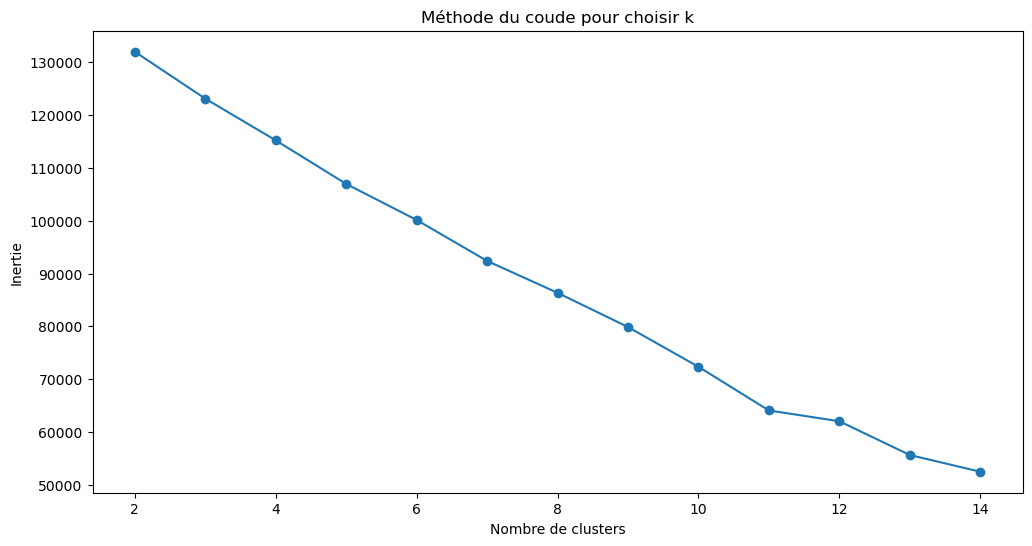

In [24]:

plt.figure(figsize=(12, 6))
plt.plot(k_list, intertia_list, marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.title("Méthode du coude pour choisir k")
plt.show()

##### Graphique du score de silhouette

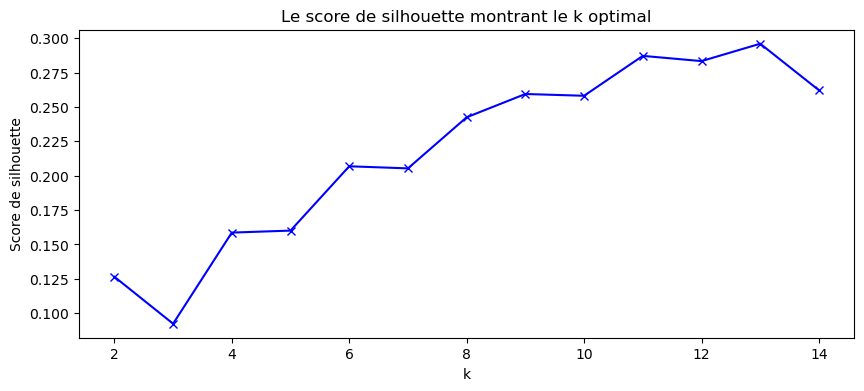

In [25]:

plt.figure(figsize=(10,4))
plt.plot(k_list, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('Score de silhouette')
plt.title('Le score de silhouette montrant le k optimal')
plt.show()

Nombre de cluster = 12

In [26]:
kmeans = KMeans(n_clusters=12, random_state=42,n_init=10 )
kmeans.fit_predict(X)
X_df["cluster"] = kmeans.labels_

In [47]:
df["cluster"] = kmeans.labels_

Visualisation avec PCA

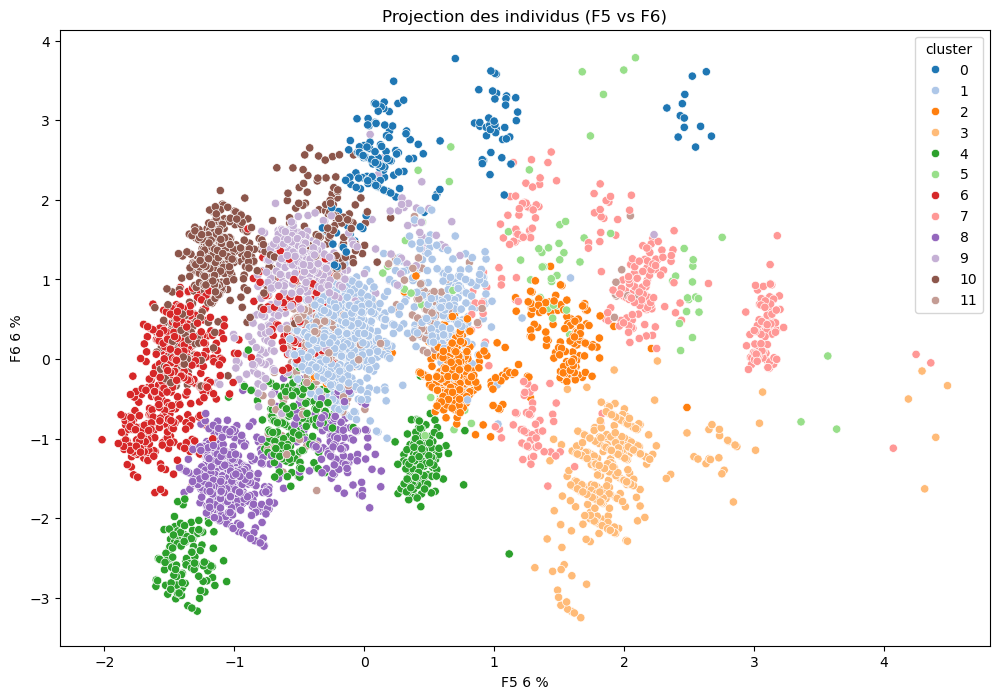

In [28]:
# Fonction de visualisation
def display_factorial_planes(X_proj, x_y, pca=None, labels=None, clusters=None, alpha=1, figsize=[10,8], marker="o"):
    X = np.array(X_proj)
    x, y = x_y

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    # c = None if clusters is None else clusters
    unique_clusters = np.unique(clusters)
    palette = sns.color_palette("tab20", len(unique_clusters))  # Plus de couleurs disponibles
    
    sns.scatterplot(x=X[:, x], y=X[:, y], hue=clusters, palette=palette, marker=marker, alpha=alpha)

    if pca:
        v1 = str(round(100 * pca.explained_variance_ratio_[x])) + " %"
        v2 = str(round(100 * pca.explained_variance_ratio_[y])) + " %"
    else:
        v1 = v2 = ''

    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')
    
    plt.title(f"Projection des individus (F{x+1} vs F{y+1})")
    plt.show()

# Affichage des clusters en projection PCA
display_factorial_planes(X_proj, [4,5], pca, clusters=df["cluster"], figsize=(12,8))

Visualisation avec TSNE

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X)
X_embedded['Cluster'] = kmeans.labels_

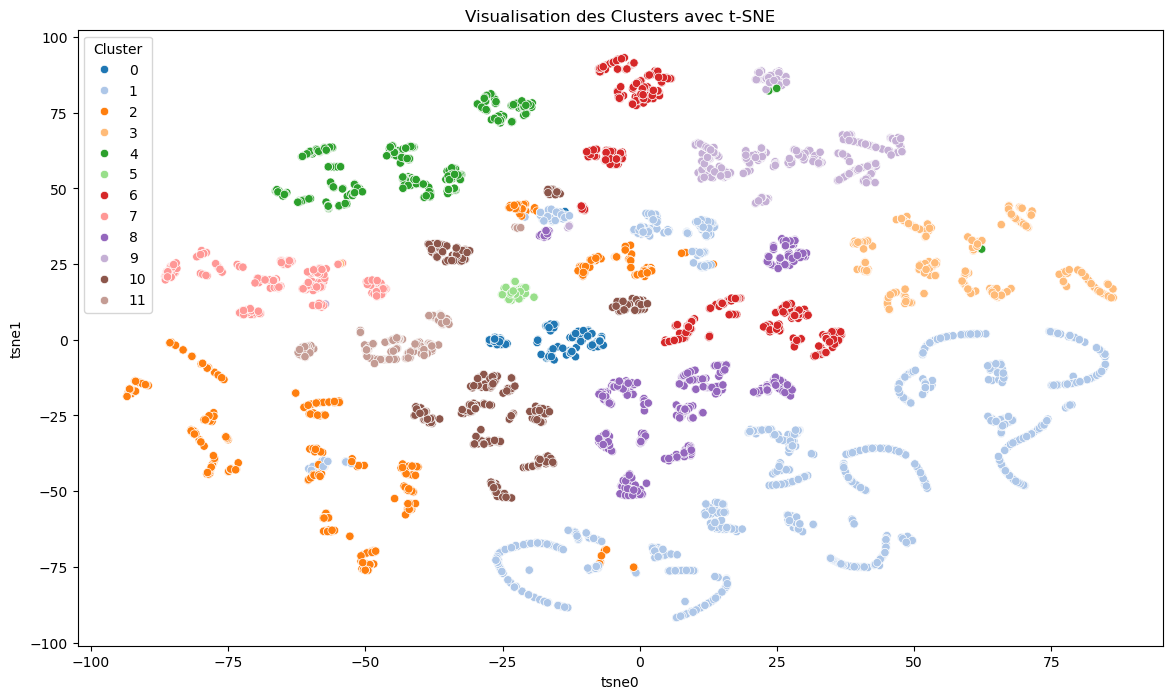

In [61]:
plt.figure(figsize=(14, 8))
unique_clusters = np.unique(X_embedded["Cluster"])
palette = sns.color_palette("tab20", len(unique_clusters))  # Plus de couleurs disponibles
sns.scatterplot(x='tsne0', y='tsne1', hue='Cluster', palette=palette, data=X_embedded, alpha=1)
plt.title('Visualisation des Clusters avec t-SNE')
plt.show()


Profilation 

In [46]:
df

,Gender,Ever_Married,Age,Graduated,Profession,Spending_Score,Family_Size,Var_1,cluster
0,Male,No,22,No,Healthcare,Low,4.0,Cat_4,4
1,Female,Yes,38,Yes,Engineer,Average,3.0,Cat_4,4
2,Female,Yes,67,Yes,Engineer,Low,1.0,Cat_6,4
3,Male,Yes,67,Yes,Lawyer,High,2.0,Cat_6,4
4,Female,Yes,40,Yes,Entertainment,High,6.0,Cat_6,4
...,...,...,...,...,...,...,...,...,...
8062,Male,Yes,41,Yes,Artist,High,5.0,Cat_6,4
8064,Male,No,35,No,Executive,Low,4.0,Cat_4,4
8065,Female,No,33,Yes,Healthcare,Low,1.0,Cat_6,4
8066,Female,No,27,Yes,Healthcare,Low,4.0,Cat_6,4


In [59]:
df[df["cluster"]==6][["Profession","Graduated","Spending_Score","Gender"]].value_counts()

Profession  Graduated  Spending_Score  Gender
Engineer    No         Low             Female    158
            Yes        Low             Female    147
            No         Average         Female     85
            Yes        Average         Female     57
            No         Low             Male       37
                       Average         Male       32
            Yes        Low             Male       29
                       High            Female     28
                       Average         Male       22
            No         High            Female     19
                                       Male        4
            Yes        High            Male        2
Name: count, dtype: int64